# Ventral Decoding on Onset Phoneme Monitoring

In [1]:
#Load the required libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Model,load_model
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
import re
import json
import seaborn as sns

from IPython.display import display, HTML
from pdb import set_trace

%matplotlib inline
sns.set()

## Data Preprocessing

In [2]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('/PATH/dicts/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('/PATH/dicts/PhonMo_Final.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['full'] = partition['train'] + partition['validation'] + partition['test']
partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [3]:
#Define the Data Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=8800, dim=(226,211), #n_channels=1,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*8800:(index+1)*8800] #7900 become 800 for the val data
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        #check shape
        #print('X : shape = %s, type = %s' % (X.shape, X.dtype) ) # If np.array
        #print('y : shape = %s, type = %s' % (y.shape, y.dtype) )

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, 226)) #226 is the max len here
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('/PATH/Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]
        
        self.my_labels = y
       
        return X, y#keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
# Parameters for the Data Generator
params = {'dim': (226,211),
          'batch_size': 8800,
          'n_classes': 7,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
full_generator = DataGenerator(partition['full'], labels, **params)
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [5]:
#Load the model and chose the penultimate layer
import tensorflow as tf

model = tf.keras.models.load_model('/bestventralmodel.hd5f')
#model.summary()
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('lstm').output)
intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, 226, 211)]        0         
_________________________________________________________________
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
Total params: 1,482,752
Trainable params: 1,482,752
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Get the features from the model for the test data
features = intermediate_layer_model.predict(full_generator, verbose=0)
print(features.shape)
features = features[:,0:226,:] #to choose the features from the first 25 time slices
features = features.reshape(8800,226*512) # reshape so that 3D to 2D
print(features.shape)

(8800, 226, 512)
(8800, 115712)


In [8]:
#Get the labels from the Data Generator
y = full_generator.my_labels[:,0]
y = np.array(y, dtype='int64')
print(y.shape)
#save('y.npy', y)

(8800,)


In [9]:
#put the features to a data frame
data = pd.DataFrame(features) #X_new if you do feature selection
#data.head()

#Get word IDs from the Data Generator
data = pd.DataFrame(data, columns=data.columns, index=data.index)
data['Words'] = np.array(full_generator.my_list)
data = data.set_index('Words')

#Get the labels from the Data Generator
#data['Labels'] = test_generator.my_labels[:,0]

#save the data frame and look at the data
#data.to_csv('/autofs/space/euler_001/users/lstm/data.csv')
data.head

<bound method NDFrame.head of                       0         1         2         3         4       \
Words                                                                  
walks-Bruce        -0.069842 -0.102295 -0.065459  0.071495 -0.040873   
fast-Fred          -0.089328 -0.113664 -0.038376  0.126269 -0.051030   
blames-Vicki       -0.066569 -0.123344 -0.056902  0.118121 -0.055702   
strange-Fred       -0.094578 -0.078570 -0.021740  0.075119 -0.029314   
replace-Fred       -0.078310 -0.089604 -0.062081  0.055622 -0.036702   
...                      ...       ...       ...       ...       ...   
denial-Victoria    -0.071730 -0.075637 -0.056202  0.053967 -0.029049   
endorsing-Princess -0.061588 -0.115768 -0.054561  0.106999 -0.054732   
protected-Kathy    -0.065155 -0.137232 -0.048378  0.145976 -0.065362   
denying-Princess   -0.068001 -0.114209 -0.054975  0.092402 -0.053292   
affiliates-Fred    -0.084188 -0.104880 -0.052280  0.082564 -0.042522   

                      5         6

# Steps to Clustering

## PCA for Just Visual

In [10]:
#Scaling and Dimensionality Reduction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pipeline = Pipeline(steps=[
  ('scaler', StandardScaler(with_mean=False)),
  ('dim_reduction', PCA(n_components=100, random_state=0))
])

pc = pipeline.fit_transform(data)

# plt.figure(figsize=(6, 5))
# sns.scatterplot(x=pc[:,0], y=pc[:,1])
# plt.xlabel("PC1")
# plt.ylabel("PC2");

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8800 samples in 0.001s...
[t-SNE] Computed neighbors for 8800 samples in 1.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8800
[t-SNE] Computed conditional probabilities for sample 2000 / 8800
[t-SNE] Computed conditional probabilities for sample 3000 / 8800
[t-SNE] Computed conditional probabilities for sample 4000 / 8800
[t-SNE] Computed conditional probabilities for sample 5000 / 8800
[t-SNE] Computed conditional probabilities for sample 6000 / 8800
[t-SNE] Computed conditional probabilities for sample 7000 / 8800
[t-SNE] Computed conditional probabilities for sample 8000 / 8800
[t-SNE] Computed conditional probabilities for sample 8800 / 8800
[t-SNE] Mean sigma: 21.029895
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.797440
[t-SNE] KL divergence after 1000 iterations: 0.430145


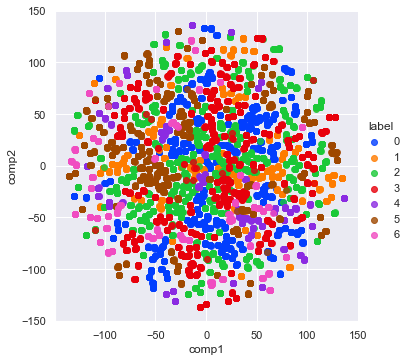

In [16]:
# randomly sample data to run quickly
rows = np.arange(8800)
np.random.shuffle(rows)
n_select = 10000

# reduce dimensionality with t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(pc[rows[:n_select],:])
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.set_palette("bright")#("rocket", as_cmap=True)
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

In [11]:
#Print out the PCA explained variance
x = StandardScaler(with_mean=False).fit_transform(data)
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.05763964 0.04521334]


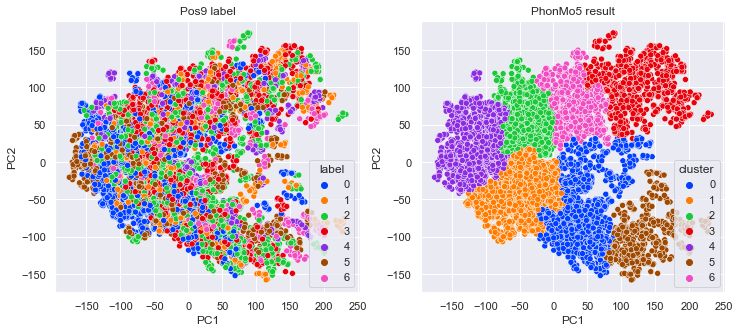

In [12]:
#Just for plotting purposes we use PCA and plot the data on two best features after PCA.
# Create clusters using Agglomerative hierarchical clustering#
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 7, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(pc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, palette='bright', ax=ax1);
ax1.set(xlabel="PC1", ylabel="PC2", title="Pos9 label")
ax1.legend(title='label')

sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y_cluster, palette='bright', ax=ax2);
ax2.set(xlabel="PC1", ylabel="PC2", title="PhonMo5 result")
ax2.legend(title='cluster');

## Normal Clustering using all the Features

In [13]:
#Now we go back to data and use Scaling and do the Clustering on 512 features
scaled_data = StandardScaler(with_mean=False).fit_transform(data)
print(scaled_data.shape)

#Doing the clustering based on 512 features
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters = 7, affinity='euclidean', linkage='ward', compute_full_tree=True)
y_cluster = agc.fit_predict(scaled_data)

(8800, 115712)


In [14]:
#Let's see how the data looks like after clustering
data = pd.DataFrame(scaled_data)
pc_data = pd.DataFrame(data, columns=data.columns, index=data.index)
pc_data['cluster'] = y_cluster
pc_data['Words'] = np.array(full_generator.my_list)
pc_data = pc_data.set_index('Words')

pc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,115703,115704,115705,115706,115707,115708,115709,115710,115711,cluster
Words,,,,,,,,,,,,,,,,,,,,,
turn-Junior,-6.423808,-6.539097,-5.383197,3.225919,-5.419266,3.546598,2.528330,-1.258489,1.683151,1.737852,...,0.800777,0.188076,8.186499,0.206499,0.207183,1.771598,-0.115024,0.160572,-1.352833,0
action-Victoria,-4.049163,-6.977403,-6.512593,3.519385,-6.021631,5.761433,1.953052,-1.094486,4.172011,2.150539,...,-0.210180,0.001838,0.006969,-2.399538,1.644829,1.512440,1.712114,-1.583256,0.255925,1
looking-Fred,-6.467959,-6.801323,-6.058725,2.788157,-4.830173,3.884298,3.563311,-3.291336,1.795856,1.654430,...,1.822785,0.033951,0.020435,1.915341,2.393624,1.705943,-1.578194,1.134730,-1.114581,4
blamed-Fred,-6.887834,-5.921033,-5.564834,2.719399,-4.834426,3.454321,2.837240,-2.414662,1.397914,2.075668,...,1.875018,-1.749438,0.003973,-0.000063,1.936089,-0.005259,-1.542863,0.507335,-0.038609,0
hope-Junior,-5.963575,-6.586229,-3.724394,4.878587,-6.873921,3.641882,3.019119,-1.421673,3.940977,4.170372,...,-0.200924,0.406922,0.059154,2.501608,0.551855,0.142833,0.198320,0.632211,-0.003353,5


In [15]:
#cluster counts
CC = np.bincount(y_cluster)
print ("Cluster Counts:", CC)
#true class counts
TC = np.bincount(y)
print ("True Label Counts:", TC)

Cluster Counts: [2151 1607 1034 1845  361  442 1360]
True Label Counts: [1653  866 2076 1766  553 1366  520]


In [16]:
# Find the size of the clusters
pc_data["cluster"].value_counts()

0    2151
3    1845
1    1607
6    1360
2    1034
5     442
4     361
Name: cluster, dtype: int64

## Clustering performance evaluation

In [19]:
from sklearn import metrics
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [0, 0, 1, 1, 2, 2]
labels_true = y
labels_pred = y_cluster

In [28]:
# Mutual Information based scores
print ("Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print ("Normalized Mutual Info:", metrics.normalized_mutual_info_score(labels_true, labels_pred))
print ("Adjusted Mutual Info:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
#Perfect labeling is scored 1.0, bad labeling have non-positive scores.

Mutual Info: 0.11839275759542552
Normalized Mutual Info: 0.11938618162392295
Adjusted Mutual Info: 0.11839275759542552
